# Dataset

The file contains information about a test matrix of solvers and graphs. Specifically, it reports the time in milliseconds for each run, the memory usage\* in MB, whether the graph was colored successfully, and how many colors it took.

\*: the memory usage is not reported correctly because the glibc allocator sometimes does not free memory in order to reuse it later.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rgg_data = pd.read_csv("rgg-graphs.csv")
rgg_data.head()

,Graph,Vertices,Edges,Solver,Time elapsed,Memory usage,Success,Colors
0,rgg_n_2_15_s0.graph.fast,32768,342568,SequentialSolver,16.73,8.13,1,15
1,rgg_n_2_15_s0.graph.fast,32768,342568,LubySolver (1 threads),192.62,10.87,1,14
2,rgg_n_2_15_s0.graph.fast,32768,342568,LubySolver (2 threads),156.31,8.13,1,14
3,rgg_n_2_15_s0.graph.fast,32768,342568,LubySolver (4 threads),139.80,16.26,1,15
4,rgg_n_2_15_s0.graph.fast,32768,342568,JonesSolver (1 threads),19.68,0.00,1,15


# Correctness

We confirm empirically that all solvers were implemented correctly. Nevertheless, some use more colors than others: it seems that LDF is the best solver in this regard, and SDL is the worst. Notice that the number of colors may differ for the same algorithm with a different number of threads.

In [2]:
print("Graphs colored incorrectly:", sum(rgg_data["Success"] == 0))
pd.DataFrame(rgg_data.groupby(["Graph", "Solver"]).apply(lambda df: df["Colors"])).reset_index(level=2, drop=True).unstack()

Graphs colored incorrectly: 0


Colors                        \
Solver                   FVFSolver (1 threads) FVFSolver (2 threads)   
Graph                                                                  
rgg_n_2_15_s0.graph.fast                    14                    14   
rgg_n_2_16_s0.graph.fast                    16                    16   
rgg_n_2_17_s0.graph.fast                    17                    17   
rgg_n_2_18_s0.graph.fast                    18                    18   
rgg_n_2_19_s0.graph.fast                    20                    20   
rgg_n_2_20_s0.graph.fast                    19                    19   
rgg_n_2_21_s0.graph.fast                    22                    22   
rgg_n_2_22_s0.graph.fast                    22                    22   
rgg_n_2_23_s0.graph.fast                    24                    24   
rgg_n_2_24_s0.graph.fast                    24                    24   

                                                                        \
Solver                   FVFSolver (4 threads) JonesSolver (1 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                    14                      15   
rgg_n_2_16_s0.graph.fast                    16                      17   
rgg_n_2_17_s0.graph.fast                    17                      16   
rgg_n_2_18_s0.graph.fast                    18                      19   
rgg_n_2_19_s0.graph.fast                    20                      19   
rgg_n_2_20_s0.graph.fast                    19                      20   
rgg_n_2_21_s0.graph.fast                    22                      22   
rgg_n_2_22_s0.graph.fast                    22                      22   
rgg_n_2_23_s0.graph.fast                    24                      23   
rgg_n_2_24_s0.graph.fast                    24                      24   

                                                                          \
Solver                   JonesSolver (2 threads) JonesSolver (4 threads)   
Graph                                                                      
rgg_n_2_15_s0.graph.fast                      15                      15   
rgg_n_2_16_s0.graph.fast                      17                      17   
rgg_n_2_17_s0.graph.fast                      16                      16   
rgg_n_2_18_s0.graph.fast                      19                      19   
rgg_n_2_19_s0.graph.fast                      19                      19   
rgg_n_2_20_s0.graph.fast                      20                      20   
rgg_n_2_21_s0.graph.fast                      22                      22   
rgg_n_2_22_s0.graph.fast                      22                      22   
rgg_n_2_23_s0.graph.fast                      23                      23   
rgg_n_2_24_s0.graph.fast                      24                      24   

                                                                      \
Solver                   LDFSolver (1 threads) LDFSolver (2 threads)   
Graph                                                                  
rgg_n_2_15_s0.graph.fast                    14                    14   
rgg_n_2_16_s0.graph.fast                    15                    15   
rgg_n_2_17_s0.graph.fast                    16                    16   
rgg_n_2_18_s0.graph.fast                    17                    17   
rgg_n_2_19_s0.graph.fast                    19                    19   
rgg_n_2_20_s0.graph.fast                    19                    19   
rgg_n_2_21_s0.graph.fast                    20                    20   
rgg_n_2_22_s0.graph.fast                    21                    21   
rgg_n_2_23_s0.graph.fast                    23                    23   
rgg_n_2_24_s0.graph.fast                    22                    22   

                                                                       \
Solver                   LDFSolver (4 threads) LubySolver (1 threads)   
Graph                                                               

# Time elapsed (log-log plot)

We observe that there is a very noticeable difference (approx. 1 order of magnitude) between Luby solvers and other algorithms. Furthermore, at small sizes these algorithms are comparable in their speed, but as the number of vertices increases we can see a further subdivision, with the sequential/random-selection algorithms being a bit slower than others.

<IPython.core.display.Javascript object>


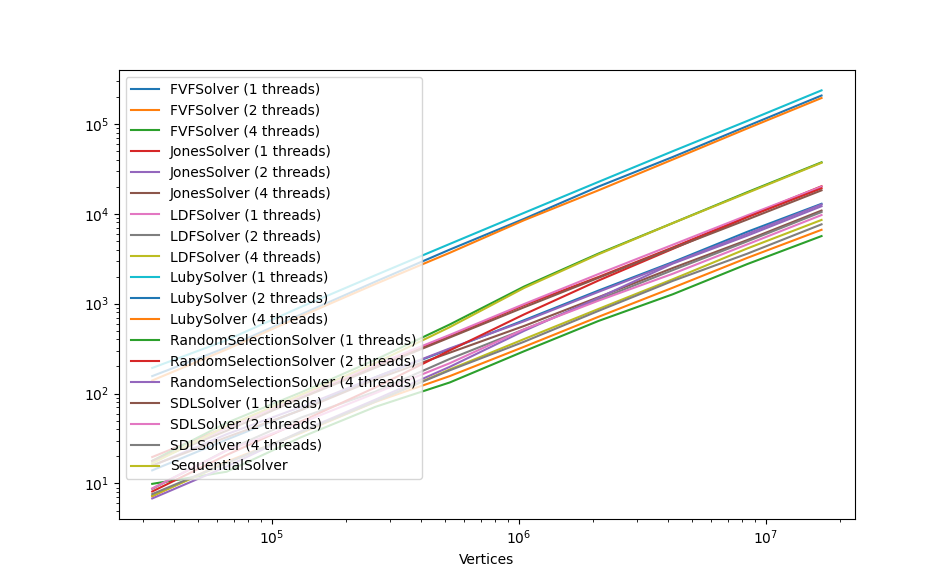

In [3]:
%matplotlib notebook

rgg_by_solver = rgg_data.groupby("Solver")
fig, ax = plt.subplots()
for solver_name, data in rgg_by_solver:
    data.plot(ax=ax, x="Vertices", y="Time elapsed", loglog=True, label=solver_name)

# Nodes per second

We can now inspect performance data more in detail. We can see that at small graph sizes "heuristic" multithreaded algorithms perform very well; among those mentioned in papers, Jones performs very well with multiple threads.

As the graph size increases we observe several interesting trends (many of which can be seen in the log-log plot and now quantified):

 - FVF, SDL and LDF are clearly the best performers;
 - Heuristic solvers get smaller improvements from multithreading;
 - Jones on the other hand achieves a better speedup;
 - the LDF heuristic scales significantly better than the random one (1.9x vs 3.6x slowdown).

In [4]:
pd.DataFrame(rgg_data.groupby(["Graph", "Solver"]).apply(lambda df: df["Vertices"]/df["Time elapsed"])).reset_index(level=2, drop=True).unstack().astype(int)
#rgg_data.groupby(["Graph", "Solver"]).head()

0                        \
Solver                   FVFSolver (1 threads) FVFSolver (2 threads)   
Graph                                                                  
rgg_n_2_15_s0.graph.fast                  2342                  4544   
rgg_n_2_16_s0.graph.fast                  2134                  3749   
rgg_n_2_17_s0.graph.fast                  1986                  3597   
rgg_n_2_18_s0.graph.fast                  1728                  3246   
rgg_n_2_19_s0.graph.fast                  1682                  3355   
rgg_n_2_20_s0.graph.fast                  1602                  3164   
rgg_n_2_21_s0.graph.fast                  1500                  2938   
rgg_n_2_22_s0.graph.fast                  1445                  2787   
rgg_n_2_23_s0.graph.fast                  1333                  2600   
rgg_n_2_24_s0.graph.fast                  1300                  2530   

                                                                        \
Solver                   FVFSolver (4 threads) JonesSolver (1 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                  3309                    1665   
rgg_n_2_16_s0.graph.fast                  4854                    1547   
rgg_n_2_17_s0.graph.fast                  4016                    1426   
rgg_n_2_18_s0.graph.fast                  3685                    1290   
rgg_n_2_19_s0.graph.fast                  3948                    1203   
rgg_n_2_20_s0.graph.fast                  3547                    1088   
rgg_n_2_21_s0.graph.fast                  3267                    1059   
rgg_n_2_22_s0.graph.fast                  3297                     993   
rgg_n_2_23_s0.graph.fast                  3046                     900   
rgg_n_2_24_s0.graph.fast                  2971                     829   

                                                                          \
Solver                   JonesSolver (2 threads) JonesSolver (4 threads)   
Graph                                                                      
rgg_n_2_15_s0.graph.fast                    2088                    2063   
rgg_n_2_16_s0.graph.fast                    1858                    2006   
rgg_n_2_17_s0.graph.fast                    1846                    2006   
rgg_n_2_18_s0.graph.fast                    1724                    1820   
rgg_n_2_19_s0.graph.fast                    1650                    1841   
rgg_n_2_20_s0.graph.fast                    1646                    1857   
rgg_n_2_21_s0.graph.fast                    1550                    1778   
rgg_n_2_22_s0.graph.fast                    1481                    1683   
rgg_n_2_23_s0.graph.fast                    1404                    1647   
rgg_n_2_24_s0.graph.fast                    1322                    1546   

                                                                      \
Solver                   LDFSolver (1 threads) LDFSolver (2 threads)   
Graph                                                                  
rgg_n_2_15_s0.graph.fast                  1894                  3757   
rgg_n_2_16_s0.graph.fast                  1578                  2800   
rgg_n_2_17_s0.graph.fast                  1393                  2425   
rgg_n_2_18_s0.graph.fast                  1255                  2498   
rgg_n_2_19_s0.graph.fast                  1168                  2161   
rgg_n_2_20_s0.graph.fast                  1059                  2027   
rgg_n_2_21_s0.graph.fast                   982                  1886   
rgg_n_2_22_s0.graph.fast                   927                  1776   
rgg_n_2_23_s0.graph.fast                   875                  1701   
rgg_n_2_24_s0.graph.fast                   837                  1604   

                                                                       \
Solver                   LDFSolver (4 threads) LubySolver (1 threads)   
Graph                                                                   


# Parser

We immediately see that FastParser provides a significant and consistent performance improvement of about 5x, even over a multithreaded version of the DIMACS-10 parser.

In [5]:
fastparser_data = pd.read_csv("parse-fast.csv", sep=";", names=["Graph", "Vertices", "Edges", "Time (ms)"])
fastparser_data["Parser"] = "FastParser"
fastparser_data["Graph"] = fastparser_data["Graph"].apply(lambda file: file[:-5])
dimacs10parser_data = pd.read_csv("parse-slow.csv", sep=";", names=["Graph", "Vertices", "Edges", "Time (ms)"])
dimacs10parser_data["Parser"] = "DIMACS-10"
parser_data = pd.concat([fastparser_data, dimacs10parser_data])
pd.DataFrame(parser_data.groupby(["Graph", "Parser"]).apply(lambda df: df["Time (ms)"])).reset_index(level=2, drop=True).unstack()

Time (ms)           
Parser              DIMACS-10 FastParser
Graph                                   
rgg_n_2_15_s0.graph        83          8
rgg_n_2_16_s0.graph       102         20
rgg_n_2_17_s0.graph       256         45
rgg_n_2_18_s0.graph       476         86
rgg_n_2_19_s0.graph       870        185
rgg_n_2_20_s0.graph      1939        365
rgg_n_2_21_s0.graph      3363        751
rgg_n_2_22_s0.graph      7353       1632
rgg_n_2_23_s0.graph     15728       3294
rgg_n_2_24_s0.graph     32710       6352

# Conclusions

The choice of algorithm results in vastly different performances. Early multithread algorithms found in literature may perform significantly worse than simpler single-thread ones, and thus be only of theoretical interest; more recent ones typically provide a measurable speedup. Simple heuristics like FVF and SDL can outperform such algorithms, as they rarely miscolor the graph and such errors can be corrected quickly.

The case of FastParser is of special interest as a problem that has a "structural" bottleneck (parsing millions of numbers). Although the performance can be improved by using multiple threads, it is best addressed by design decisions that avoid the bottleneck (in our case, translating the graph as a binary file).